# <span style="color:black">This notebook includes the gender bias study on the extracted quotes.</span>

## <span style="color:black">Mount drive to notebook</span>

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)


Mounted at /content/drive


## <span style="color:black">Install needed packages</span>

In [ ]:
!pip install tld
!pip install pandas==1.0.5

import os
import bz2
import json
import glob
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from utils import process_chunk, process_text, manual_extraction, ids_to_tweets, embedSentence, embedding, averageEmbedding, featurize

#Packages for url parsing
import tld
from tld import get_tld
import requests
from urllib.request import urlopen
from bs4 import BeautifulSoup
from urllib.request import urlopen
#Packages for dimentionality reduction
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from nltk.tokenize.treebank import TreebankWordDetokenizer
#Packages for NLP methods
import re
import nltk
import gensim
from gensim import models
from gensim import corpora
import gensim.downloader as api
from gensim.test.utils import datapath, common_texts
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
# We need this dataset in order to use the tokenizer
nltk.download('punkt')
# Also download the list of stopwords to filter out
nltk.download('stopwords')
stemmer = PorterStemmer()

# Add constants/paths
_DATASETS_PATHS = '/content/drive/Shareddrives/ADA LUNATICS 2021/datasets'

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
def process_chunk(chunk):
  '''This function merges the quote chunks with the metadata based on speaker'''
  merge = pd.merge(chunk, clean_metadata, how='inner',left_on='speaker', right_on='label' )
  return merge

# This function enables us to convert gender QIDs to either "male, female or other"

def process_gender(df, male_list, female_list): 
  '''This function converts QIDs into gender categories (M/F/Others)'''
  df['gender'] = df['gender'].astype('str').apply(lambda x: x.replace('[', '').replace(']', ''))
  df['gender'] = df['gender'].astype('str').apply(lambda x: x.replace("'", '').replace(']', ''))
  df['gender'] = df['gender'].apply(lambda x : x.split(' ')[0])
  
  #assign genders to categories male and female
  df['gender'] = df['gender'].apply(lambda x: 'Male' if x in male_list else x)
  df['gender'] = df['gender'].apply(lambda x: 'Female' if x in female_list else x )

  #assign last categorie : others
  change = list(df['gender'].unique())
  change.remove('Female')
  change.remove('Male')
  df['gender'] = df['gender'].apply(lambda x: 'Others' if x in change else x )
  df['gender'].unique()
  return df

In [ ]:
#Loading the originally extracted 6M quptes after key-word based extraction
keywords_quotes_path = '/content/drive/Shareddrives/ADA LUNATICS 2021/datasets/keywords-extracted-data.csv.bz2'
metoo_quotes_path = '/content/drive/Shareddrives/ADA LUNATICS 2021/datasets/final_filtered_quotes.csv.bz2'
quotes = pd.read_csv(metoo_quotes_path, compression='bz2')
quotes.head()

,Unnamed: 0,quoteID,quotation,speaker,qids,date,probas,urls
0,2,2015-10-18-002421,"All have sinned, am I right about it?",None,[],2015-10-18 22:56:39,"[['None', '0.8051'], ['Dylann Roof', '0.1949']]",['http://www.thestate.com/news/state/charlesto...
1,3,2015-03-04-003313,allow these abuses in the Church to go on and ...,None,[],2015-03-04 22:21:05,"[['None', '0.4972'], ['Tom Cruise', '0.1883'],...",['http://feeds.cbsnews.com/~r/CBSNewsEntertain...
2,7,2015-08-13-036996,"I have been young, and now am old; Yet have I ...",None,[],2015-08-13 16:16:52,"[['None', '0.8226'], ['Charles Schumer', '0.10...",['http://blogs.timesofisrael.com/when-will-jew...
3,8,2015-01-03-001772,"And you are totally alone, it became nearly fr...",Tony Hall,"['Q21597856', 'Q33675022', 'Q7822516', 'Q78225...",2015-01-03 13:15:00,"[['Tony Hall', '0.7603'], ['None', '0.2397']]",['http://www.theage.com.au/nsw/the-great-austr...
4,9,2015-07-29-039943,"I live in Bushwick, a ghetto in Brooklyn, and ...",Natasha Lyonne,['Q234207'],2015-07-29 01:05:20,"[['Natasha Lyonne', '0.7154'], ['None', '0.274...",['http://deadline.com/print-article/1201486676...


In [ ]:
speakers = pd.DataFrame(quotes.speaker)

In [ ]:
# Loading the speakers metadata
df_metadata = pd.read_parquet('/content/drive/Shareddrives/ADA LUNATICS 2021/datasets/speaker_attributes.parquet')
#cleaning df_medata from duplicates
clean_metadata = df_metadata.drop_duplicates(subset='label', keep=False)
# Only keep the categories relevant to us:
clean_metadata = clean_metadata[['label','date_of_birth', 'nationality', 'gender', 'ethnic_group', 'academic_degree', 'religion' ]]
clean_metadata.head()

,label,date_of_birth,nationality,gender,ethnic_group,academic_degree,religion
2,Paul Otlet,[+1868-08-23T00:00:00Z],[Q31],[Q6581097],None,None,None
5,Augusto Pinochet,[+1915-11-25T00:00:00Z],[Q298],[Q6581097],None,None,[Q1841]
6,Charles Baudelaire,[+1821-04-09T00:00:00Z],[Q142],[Q6581097],[Q121842],None,[Q1841]
7,Nicolaus Copernicus,[+1473-02-19T00:00:00Z],[Q1649871],[Q6581097],[Q1026],None,[Q1841]
9,Harald Krichel,[+1969-00-00T00:00:00Z],[Q183],[Q6581097],None,None,None


In [ ]:
# parsing with only rows with known speakers

merge = process_chunk(quotes.replace(to_replace='None', value=np.nan).dropna(subset=['speaker']))
merge.to_csv(path_or_buf='/content/drive/Shareddrives/ADA LUNATICS 2021/datasets/200k_speakers_metadata.csv.bz2', compression='bz2')
total_size = len(merge)



In [ ]:
clean_metadata = pd.read_csv("/content/drive/Shareddrives/ADA LUNATICS 2021/datasets/200k_speakers_metadata.csv.bz2", compression='bz2')
clean_metadata.head()

,Unnamed: 0,Unnamed: 0.1,quoteID,quotation,speaker,qids,date,probas,urls,label,date_of_birth,nationality,gender,ethnic_group,academic_degree,religion
0,0,9,2015-07-29-039943,"I live in Bushwick, a ghetto in Brooklyn, and ...",Natasha Lyonne,['Q234207'],2015-07-29 01:05:20,"[['Natasha Lyonne', '0.7154'], ['None', '0.274...",['http://deadline.com/print-article/1201486676...,Natasha Lyonne,['+1979-04-04T00:00:00Z'],['Q30'],['Q6581072'],NaN,NaN,NaN
1,1,823565,2019-06-13-039399,I think often of the other young women who are...,Natasha Lyonne,['Q234207'],2019-06-13 16:47:17,"[['Natasha Lyonne', '0.6729'], ['None', '0.327...",['http://etonline.com/natasha-lyonne-russian-d...,Natasha Lyonne,['+1979-04-04T00:00:00Z'],['Q30'],['Q6581072'],NaN,NaN,NaN
2,2,854629,2019-03-10-020813,"In women, we embrace that in each other, that ...",Natasha Lyonne,['Q234207'],2019-03-10 21:34:15,"[['Natasha Lyonne', '0.6977'], ['None', '0.302...",['https://www.dailydot.com/upstream/natasha-ly...,Natasha Lyonne,['+1979-04-04T00:00:00Z'],['Q30'],['Q6581072'],NaN,NaN,NaN
3,3,39,2015-11-11-029906,"Holy hots, why not child sex robots?.",Tom O'Carroll,['Q3299310'],2015-11-11 18:34:00,"[[""Tom O'Carroll"", '0.8832'], ['None', '0.1168']]",['http://www.mirror.co.uk/news/uk-news/twisted...,Tom O'Carroll,['+1945-08-08T00:00:00Z'],['Q145'],['Q6581097'],NaN,NaN,NaN
4,4,41,2015-05-13-034874,It's for a photo shoot or a purpose outside of...,Asa Akira,['Q233092'],2015-05-13 16:11:40,"[['Asa Akira', '0.7276'], ['None', '0.2724']]",['http://dailydot.com/lifestyle/jessica-drake-...,Asa Akira,['+1985-01-03T00:00:00Z'],['Q30'],['Q6581072'],['Q1156766'],NaN,NaN


In [ ]:
# process gender feature to get only one gender, as a str : 'Q...'
# creating the categories male, female, others
male = ['Q6581097' , 'Q2449503' , 'Q15145778']
female = ['Q6581072' , 'Q1052281' , 'Q15145779']
# Lets study the distribution of the gender people who speak about metoo and people who speak in general
clean_metatdata = process_gender(clean_metadata, male, female)

In [ ]:
clean_metadata.groupby(["gender"]).count()

,Unnamed: 0,Unnamed: 0.1,quoteID,quotation,speaker,qids,date,probas,urls,label,date_of_birth,nationality,ethnic_group,academic_degree,religion
gender,,,,,,,,,,,,,,,
Female,32750,32750,32750,32750,32750,32750,32750,32750,32750,32750,29920,29156,4538,1119,5829
Male,27232,27232,27232,27232,27232,27232,27232,27232,27232,27232,24929,23945,3773,1262,6431
Others,1075,1075,1075,1075,1075,1075,1075,1075,1075,1075,380,367,89,35,82


#### <div style="text-align: justify"><span style="color:red">Gender Distribution in the Meta Data.</div></span>

Text(0, 0.5, '% of Quotes')

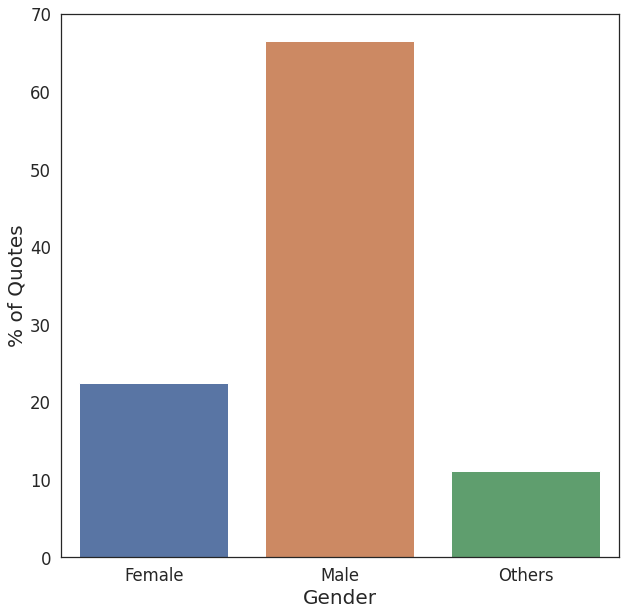

In [ ]:
# This one is for all the speakers in the metadata
#Visualize number of quotes per year
#Visualize number of quotes per year
sns.set(font_scale = 1.5)
sns.set_style("white")

x_ = ["Female", "Male", "Others"]
data = np.array([215461, 638897, 107161])
total = np.sum(data)
data = (data/total)*100
_, axis = plt.subplots(nrows=1, ncols=1, figsize=(10,10))
ax = sns.barplot(y=data, x=x_)
ax.set_ylim(0,70)

ax.set_xlabel('Gender', fontsize=20)
ax.set_ylabel('% of Quotes', fontsize=20)


#_.savefig('/content/drive/Shareddrives/ADA LUNATICS 2021/datasets/gender_150K.png')

#### <div style="text-align: justify"><span style="color:red">Gender Distribution in the Extracted Quotes.</div></span>

Text(0, 0.5, '% of Quotes')

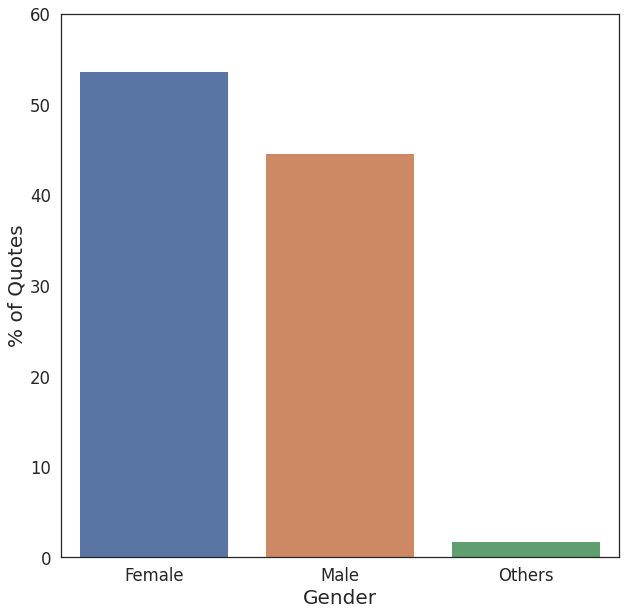

In [ ]:
#Visualize number of quotes per year
sns.set(font_scale = 1.5)
sns.set_style("white")

x_ = ["Female", "Male", "Others"]
data = np.array([32750, 27232, 1075])
total = np.sum(data)
data = (data/total)*100
_, axis = plt.subplots(nrows=1, ncols=1, figsize=(10,10))
ax = sns.barplot(y=data, x=x_)
ax.set_ylim(0,60)

ax.set_xlabel('Gender', fontsize=20)
ax.set_ylabel('% of Quotes', fontsize=20)
#_.savefig('/content/drive/Shareddrives/ADA LUNATICS 2021/datasets/gender_150K.png')

#### <div style="text-align: justify"><span style="color:red">Gender Distribution in the 6M Quotes.</div></span>

Text(0, 0.5, '% of Quotes')

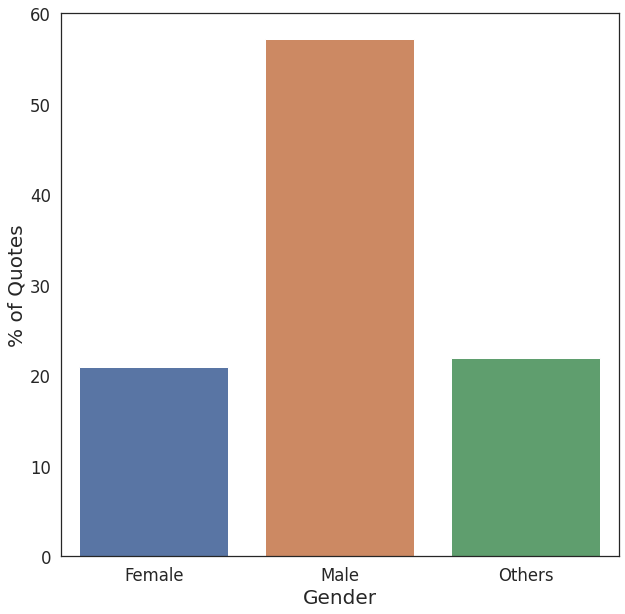

In [ ]:
#Visualize number of quotes per year
sns.set(font_scale = 1.5)
sns.set_style("white")
x_ = ["Female", "Male", "Others"]
data = np.array([1402148, 3843617, 1474021])
total = np.sum(data)
data = (data/total)*100
_, axis = plt.subplots(nrows=1, ncols=1, figsize=(10,10))
ax.set_ylim(0,60)

ax = sns.barplot(y=data, x=x_)
ax.set_xlabel('Gender', fontsize=20)
ax.set_ylabel('% of Quotes', fontsize=20)
#_.savefig('/content/drive/Shareddrives/ADA LUNATICS 2021/datasets/gender_150K.png')

#### <div style="text-align: justify"><span style="color:red">We can clearly see that the original 6M extracted quotes as well as the speaker metadata is heavily biased towards men, however the quotes related to sexual harassment tend to be spoken by women, reversing the previously observed trend! </div></span>